# Time Series Analysis with ARMA Models

This notebook demonstrates a comprehensive approach to time series analysis and forecasting using Apple stock data. The workflow covers:

- **Data acquisition and exploration**: Fetching historical stock prices and understanding their distributions
- **Stationarity testing**: Applying statistical tests (ADF, KPSS, Jarque-Bera) to assess time series properties
- **Data transformation**: Converting price levels to log returns for stationarity
- **Autocorrelation analysis**: Examining temporal dependencies through ACF and PACF plots
- **Model selection**: Using grid search with information criteria (AIC, AICC, BIC) to find optimal ARMA parameters
- **Model comparison**: Evaluating different ARMA specifications to identify the best performing model

The analysis follows best practices in financial time series modeling, including proper train-test-holdout splitting, stationarity testing before model fitting, and the use of log returns to handle non-stationary price data. Multiple ARMA models are compared using information criteria and RMSE to balance model complexity with predictive accuracy.

In [101]:
# --- Required Libraries ---
# Core data manipulation and numerical computing
import math
import numpy as np
import pandas as pd
from scipy import stats

# Financial data retrieval
import yfinance as yf

# Visualization tools
import matplotlib.pyplot as plt
import seaborn as sns

# Time series analysis and statistical testing
import statsmodels.graphics.tsaplots
import statsmodels.tsa
import statsmodels.stats.stattools
import statsmodels.stats.diagnostic

# Optimization and ARIMA modeling
from scipy.optimize import brute
from statsmodels.tsa.arima.model import ARIMA

# Model evaluation metrics
import sklearn.metrics

# Suppress warnings for cleaner output during model iterations
import warnings
warnings.filterwarnings(action="ignore")

## Data Acquisition and Initial Exploration

We begin by fetching historical stock price data and performing initial exploratory analysis to understand the basic characteristics, distributions, and patterns in the raw data.

In [ ]:
# Fetching historical data for Apple stock (AAPL) over the past 10 years
# This provides a comprehensive dataset for analyzing long-term trends and patterns
apple_tick = yf.Ticker("AAPL")
apple_history = apple_tick.history(period = "10y")

: 

: 

: 

In [ ]:
# Quick overview of the dataset structure
# Displaying first and last 5 rows to check data consistency and time range
pd.concat([apple_history.head(5), apple_history.tail(5)])

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2015-11-10 00:00:00-05:00,26.382875,26.646929,26.193297,26.353535,236511600,0.0,0.0
2015-11-11 00:00:00-05:00,26.263258,26.500229,26.001459,26.204578,180872000,0.0,0.0
2015-11-12 00:00:00-05:00,26.238431,26.364816,26.100762,26.116560,130102400,0.0,0.0
2015-11-13 00:00:00-05:00,25.999205,26.082710,25.337941,25.353739,183249600,0.0,0.0
2015-11-16 00:00:00-05:00,25.137072,25.782538,25.051311,25.768997,152426800,0.0,0.0
2025-11-04 00:00:00-05:00,268.329987,271.489990,267.619995,270.040009,49274800,0.0,0.0
2025-11-05 00:00:00-05:00,268.609985,271.700012,266.929993,270.140015,43683100,0.0,0.0
2025-11-06 00:00:00-05:00,267.890015,273.399994,267.890015,269.769989,51204000,0.0,0.0
2025-11-07 00:00:00-05:00,269.799988,272.290009,266.769989,268.470001,48203600,0.0,0.0


: 

: 

: 

## Exploratory Data Analysis (EDA)

Comprehensive statistical and visual exploration of the dataset to identify patterns, outliers, and distributional characteristics that will inform our modeling approach.

In [ ]:
# Comprehensive dataset summary including data types, missing values, and descriptive statistics
# Info provides structural details while describe offers statistical measures
print(apple_history.info())
apple_history.describe()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2515 entries, 2015-11-10 00:00:00-05:00 to 2025-11-10 00:00:00-05:00
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          2515 non-null   float64
 1   High          2515 non-null   float64
 2   Low           2515 non-null   float64
 3   Close         2515 non-null   float64
 4   Volume        2515 non-null   int64  
 5   Dividends     2515 non-null   float64
 6   Stock Splits  2515 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 157.2 KB
None


,Open,High,Low,Close,Volume,Dividends,Stock Splits
count,2515.000000,2515.000000,2515.000000,2515.000000,2.515000e+03,2515.000000,2515.000000
mean,110.788480,111.998675,109.674826,110.894125,1.034181e+08,0.003153,0.001590
std,71.539443,72.304299,70.841228,71.615154,5.836196e+07,0.025562,0.079761
min,20.546428,20.927678,20.425436,20.624050,1.579347e+07,0.000000,0.000000
25%,40.904699,41.166148,40.608468,40.895872,6.370090e+07,0.000000,0.000000
50%,116.653354,117.893393,114.978734,116.430580,9.013140e+07,0.000000,0.000000
75%,169.894959,171.682664,168.645055,170.171143,1.267940e+08,0.000000,0.000000
max,276.989990,277.320007,269.160004,271.399994,5.334788e+08,0.260000,4.000000


: 

: 

: 

C:\Users\ncesc\AppData\Local\Temp\ipykernel_24164\3009856028.py:4: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  apple_history.hist(ax=ax)


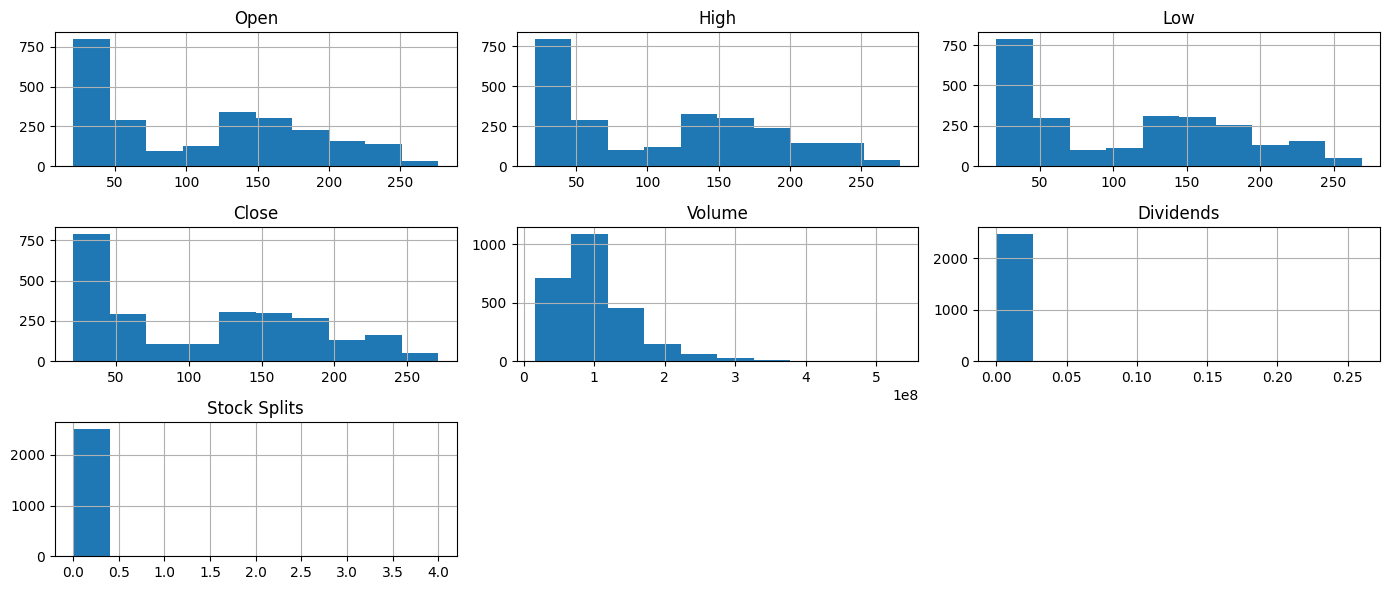

: 

: 

: 

In [ ]:
# Visualizing the distributions of all numerical variables in the dataset
# Histograms help identify skewness, outliers, and the overall shape of each variable's distribution
fig, ax = plt.subplots(figsize = (14, 6))
apple_history.hist(ax=ax)
plt.tight_layout()
plt.show()

Text(0, 0.5, 'Closing price')

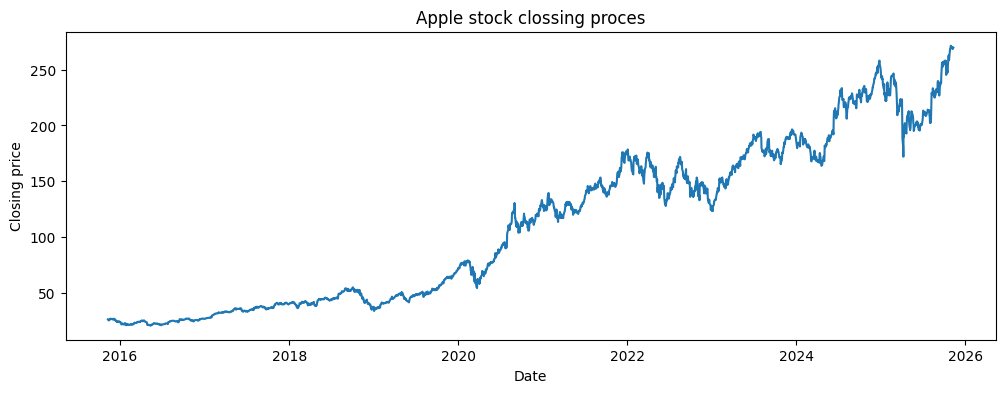

: 

: 

: 

In [ ]:
# Time series visualization of daily closing prices
# This plot reveals trends, seasonality, and potential structural breaks in the price series
appl_closing = apple_history[['Close']]

fig, ax = plt.subplots(figsize = (12, 4))
ax.plot(appl_closing)
plt.title("Apple stock clossing proces")
plt.xlabel("Date")
plt.ylabel("Closing price")

### Stationarity Testing for Raw Prices

Testing whether the raw closing price series is stationary - a critical assumption for ARMA modeling. We expect prices to be non-stationary due to trending behavior.

In [ ]:
# --- Custom functions for enhanced output readability ---
# These wrapper functions format statistical test results into easy-to-read pandas Series

# Augmented Dickey-Fuller (ADF) test for unit root detection
# Tests the null hypothesis that a unit root is present (series is non-stationary)
# Low p-values (<0.05) suggest rejecting the null, indicating stationarity
def adf_test(timeseries):
    print("Results of Dickey-Fuller Test:")
    dftest = statsmodels.tsa.stattools.adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value ({})".format(key)] = value
    print(dfoutput)

# KPSS test for stationarity
# Tests the null hypothesis that the series is stationary around a trend
# High p-values (>0.05) suggest failing to reject the null, indicating stationarity
def kpss_test(timeseries):
    print("Results of KPSS Test:")
    dftest = statsmodels.tsa.stattools.kpss(timeseries, nlags='auto')
    dfoutput = pd.Series(
        dftest[0:3],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used"
        ],
    )
    for key, value in dftest[3].items():
        dfoutput["Critical Value ({})".format(key)] = value
    print(dfoutput)

# Jarque-Bera test for normality
# Tests the null hypothesis that data follows a normal distribution
# Evaluates skewness and kurtosis to detect departures from normality
def jarque_bera(timeseries):
    print("Results of Jarque-Bera Test:")
    dftest = statsmodels.stats.stattools.jarque_bera(timeseries)
    dfoutput = pd.Series(
        dftest[:],
        index=[
            "Test Statistic",
            "p-value",
            "Skewness",
            "Kurtosis"
        ],
    )
    print(dfoutput)

: 

: 

: 

In [ ]:
# Non-rejection of the null hypothesis indicates presence of unitary root
# Therefore, the closing price series is non-stationary
adf_test(appl_closing)

Results of Dickey-Fuller Test:
Test Statistic                    0.524138
p-value                           0.985589
#Lags Used                       10.000000
Number of Observations Used    2504.000000
Critical Value (1%)              -3.432964
Critical Value (5%)              -2.862695
Critical Value (10%)             -2.567385
dtype: float64


: 

: 

: 

In [ ]:
# Rejection of the null hypothesis of stationarity
# This confirms the series is non-stationary, consistent with ADF test results
kpss_test(appl_closing)

Results of KPSS Test:
Test Statistic            7.920287
p-value                   0.010000
#Lags Used               30.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


C:\Users\ncesc\AppData\Local\Temp\ipykernel_24164\4148490571.py:28: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  dftest = statsmodels.tsa.stattools.kpss(timeseries, nlags='auto')


: 

: 

: 

In [ ]:
# Rejection of normality - stock prices typically exhibit heavy tails and skewness
jarque_bera(appl_closing)

Results of Jarque-Bera Test:
Test Statistic        [205.60990215075483]
p-value           [2.2510079852791822e-45]
Skewness             [0.29892982069329643]
Kurtosis              [1.7332536108372731]
dtype: object


: 

: 

: 

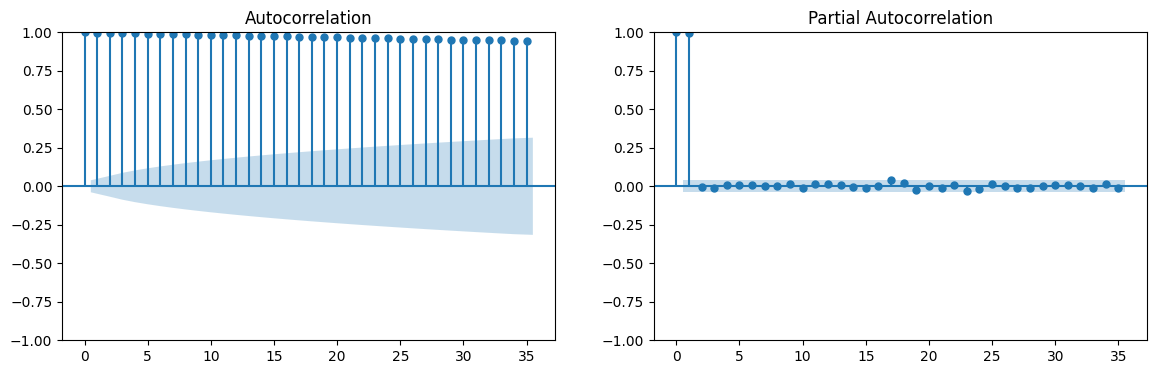

: 

: 

: 

In [ ]:
# Autocorrelation and partial autocorrelation analysis for closing prices
# ACF shows correlation of the series with its lagged values
# PACF shows direct correlation at each lag, controlling for shorter lags
fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(14, 4))

statsmodels.graphics.tsaplots.plot_acf(appl_closing, ax=ax1)
statsmodels.graphics.tsaplots.plot_pacf(appl_closing, ax=ax2)

plt.show()

### Transformation to Log Returns

Converting prices to log returns addresses non-stationarity and provides a more suitable representation for financial modeling. Log returns are approximately normally distributed and exhibit constant variance.

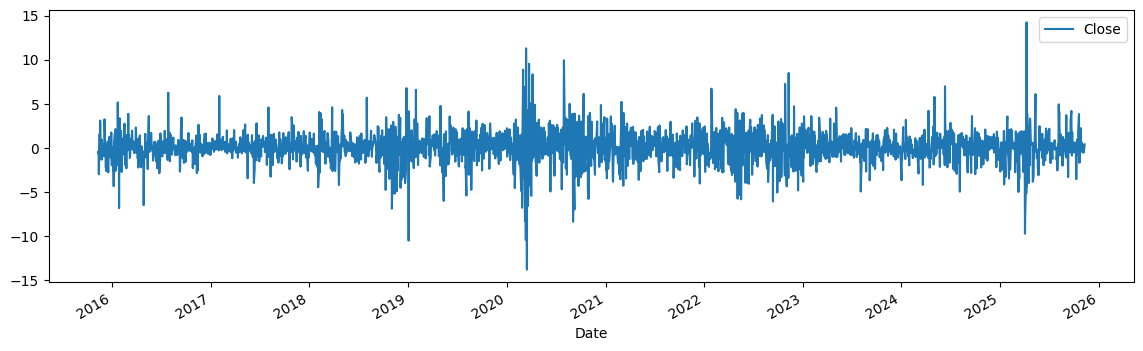

             Close
count  2514.000000
mean      0.092502
std       1.833846
min     -13.770815
25%      -0.732821
50%       0.099384
75%       1.001886
max      14.261749
mode 0.0
skewness -0.08699388363770247
kurtosis 6.5875568376729525


: 

: 

: 

In [ ]:
# Calculate log returns and multiply by 100 for percentage representation
# Log returns provide stationarity and are more appropriate for financial modeling
# They represent continuously compounded returns between consecutive observations
appl_log_ret = np.log(appl_closing).diff() * 100
appl_log_ret = appl_log_ret.dropna()

# Visualize the log returns time series
# Returns should fluctuate around zero with relatively constant variance
fig, ax = plt.subplots(figsize = (14, 4))
appl_log_ret.plot(ax=ax)
plt.show()

# Display comprehensive statistical summary including higher moments
# Mode, skewness, and kurtosis help assess distribution characteristics
print(appl_log_ret.describe(),
      f'mode {stats.mode(appl_log_ret)[0][0]}',
      f'skewness {stats.skew(appl_log_ret)[0]}',
      f'kurtosis {stats.kurtosis(appl_log_ret)[0]}',
      sep="\n")

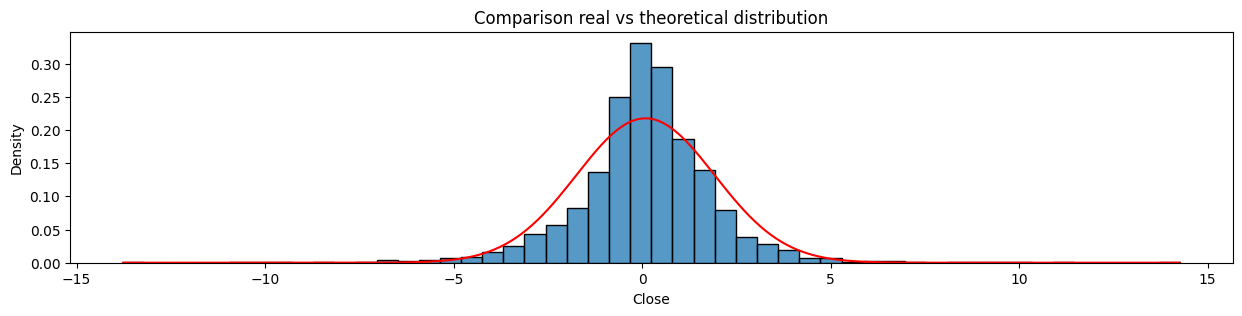

: 

: 

: 

In [ ]:
# Visual comparison between empirical distribution and theoretical normal distribution
# Overlaying a fitted normal PDF on the histogram to assess normality assumption
fig, ax = plt.subplots(figsize=(15, 3))
sns.histplot(appl_log_ret['Close'], stat='density', bins=50, kde=False, ax=ax)

# Calculate mean and standard deviation for the fitted normal distribution
mu = appl_log_ret['Close'].mean()
sigma = appl_log_ret['Close'].std()

# Generate probability density function values for the theoretical normal distribution
x = np.linspace(appl_log_ret['Close'].min(), appl_log_ret['Close'].max(), 200)
pdf = stats.norm.pdf(x, mu, sigma)

# Plot the theoretical normal distribution for visual comparison
plt.plot(x, pdf, 'r')
plt.title('Comparison real vs theoretical distribution')
plt.show()

### Retesting for Stationarity on Log Returns

Verifying that the transformation to log returns has successfully achieved stationarity. The series should now satisfy the requirements for ARMA modeling.

In [ ]:
# Rejection of the null hypothesis indicates no unit root present
# The log returns series is now stationary, suitable for ARMA modeling
adf_test(appl_log_ret)

Results of Dickey-Fuller Test:
Test Statistic                -1.613426e+01
p-value                        4.749514e-29
#Lags Used                     8.000000e+00
Number of Observations Used    2.505000e+03
Critical Value (1%)           -3.432963e+00
Critical Value (5%)           -2.862694e+00
Critical Value (10%)          -2.567385e+00
dtype: float64


: 

: 

: 

In [ ]:
# Non-rejection of the null hypothesis confirms stationarity
# Both ADF and KPSS tests now agree that the series is stationary
kpss_test(appl_log_ret)

Results of KPSS Test:
Test Statistic           0.05492
p-value                  0.10000
#Lags Used               4.00000
Critical Value (10%)     0.34700
Critical Value (5%)      0.46300
Critical Value (2.5%)    0.57400
Critical Value (1%)      0.73900
dtype: float64


C:\Users\ncesc\AppData\Local\Temp\ipykernel_24164\4148490571.py:28: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  dftest = statsmodels.tsa.stattools.kpss(timeseries, nlags='auto')


: 

: 

: 

In [ ]:
# Rejection of normality - log returns still show deviation from normal distribution
# This is common in financial data due to volatility clustering and extreme events
jarque_bera(appl_log_ret)

Results of Jarque-Bera Test:
Test Statistic       [4548.892023228797]
p-value                            [0.0]
Skewness          [-0.08699388363770247]
Kurtosis             [9.587556837672953]
dtype: object


: 

: 

: 

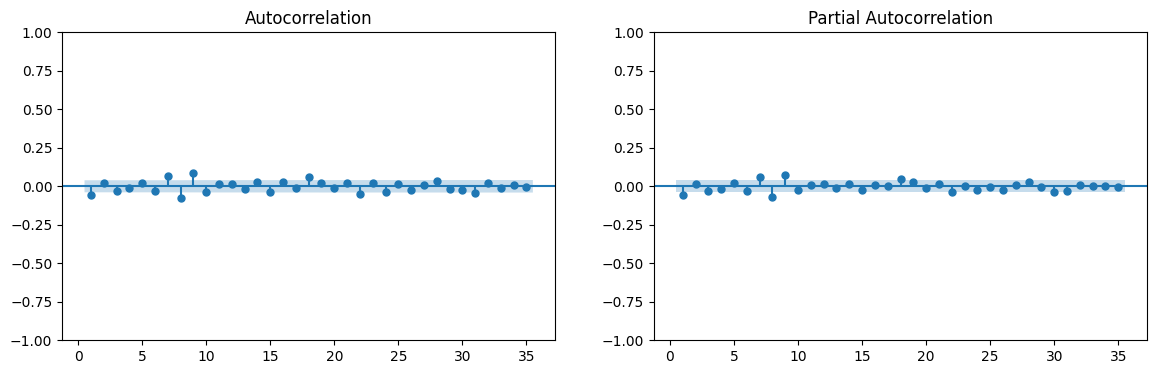

: 

: 

: 

In [ ]:
# Autocorrelation and partial autocorrelation analysis for log returns
# ACF and PACF patterns help identify appropriate AR and MA orders for ARMA modeling
# Excluding zero lag provides clearer view of temporal dependencies
fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(14, 4))

statsmodels.graphics.tsaplots.plot_acf(appl_log_ret, ax=ax1, zero= False)
statsmodels.graphics.tsaplots.plot_pacf(appl_log_ret, ax=ax2, zero= False)
plt.show()

In [ ]:
# Ljung-Box test for autocorrelation across multiple lags
# Rejection of the null hypothesis indicates significant autocorrelation exists
# This confirms that the series has temporal structure worth modeling with ARMA
statsmodels.stats.diagnostic.acorr_ljungbox(appl_log_ret, lags=20)

,lb_stat,lb_pvalue
1,8.128366,4.357799e-03
2,9.112796,1.049981e-02
3,11.647594,8.693214e-03
4,12.047701,1.700005e-02
5,13.075430,2.268207e-02
6,15.893334,1.433808e-02
7,27.211458,3.052971e-04
8,42.978997,8.864655e-07
9,61.037241,8.457506e-10
10,64.843249,4.342988e-10


: 

: 

: 

## Model Development and Selection

This section covers the complete modeling pipeline: splitting data into training, testing, and holdout sets; fitting ARMA models with different orders; and selecting the optimal specification based on information criteria and performance metrics.

### Train-Test-Holdout Data Splitting

Implementing a three-way split (60-20-20) to ensure robust model evaluation. The training set fits the model, the test set optimizes hyperparameters, and the holdout set provides final out-of-sample validation.

In [ ]:
# Calculate dataset timespan and total observations
print(appl_log_ret.index.max(),
      appl_log_ret.index.min(),
      appl_log_ret.index.max() - appl_log_ret.index.min(),
      appl_log_ret.shape,
      sep='\n')

# Using a 60-20-20 split for train-test-holdout to balance model fitting and validation
train = math.floor(len(appl_log_ret) * 0.6)
test = math.floor(len(appl_log_ret) * 0.2)

# Create sequential splits respecting temporal order (critical for time series)
train_sample = appl_log_ret.iloc[:train, :]
test_sample = appl_log_ret.iloc[train:(train+test), :]
holdout = appl_log_ret.iloc[(train+test):, :]

# Verify that splits sum to the total dataset size
print(train_sample.shape, test_sample.shape, holdout.shape, sum([train_sample.shape[0], test_sample.shape[0], holdout.shape[0]]))

2025-11-10 00:00:00-05:00
2015-11-11 00:00:00-05:00
3652 days 00:00:00
(2514, 1)
(1508, 1) (502, 1) (504, 1) 2514


: 

: 

: 

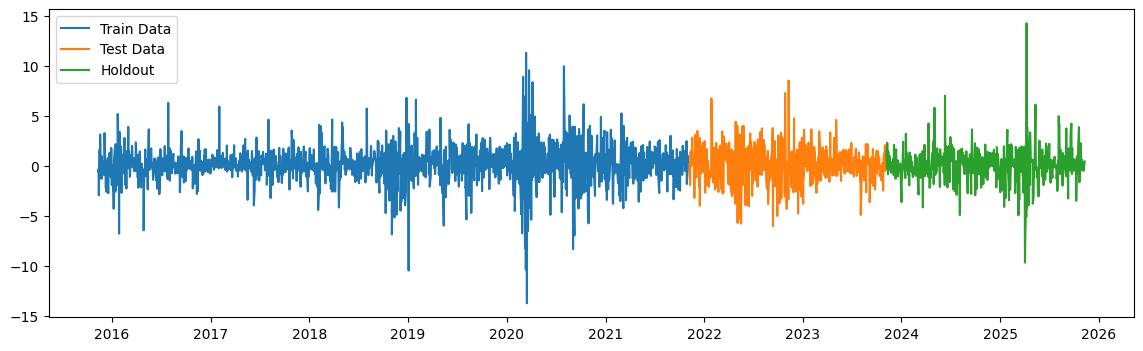

: 

: 

: 

In [ ]:
# Visualize the temporal split to ensure proper separation and sequential ordering
# Each subset should be contiguous in time with no overlap
fig, ax = plt.subplots(figsize=(14, 4))
ax.plot(train_sample, label='Train Data')
ax.plot(test_sample, label='Test Data')
ax.plot(holdout, label='Holdout')
plt.legend(loc = 'best')
plt.show()

### ARMA Model Training and Optimization

Starting with an initial model based on ACF/PACF patterns, then using systematic grid search to find optimal orders according to multiple information criteria.

In [ ]:
# Initial ARMA(1,1) model based on visual inspection of ACF and PACF plots
# This serves as a baseline before systematic optimization
arima_model = ARIMA(train_sample, order=(1, 0, 1))
arima_fit = arima_model.fit()

: 

: 

: 

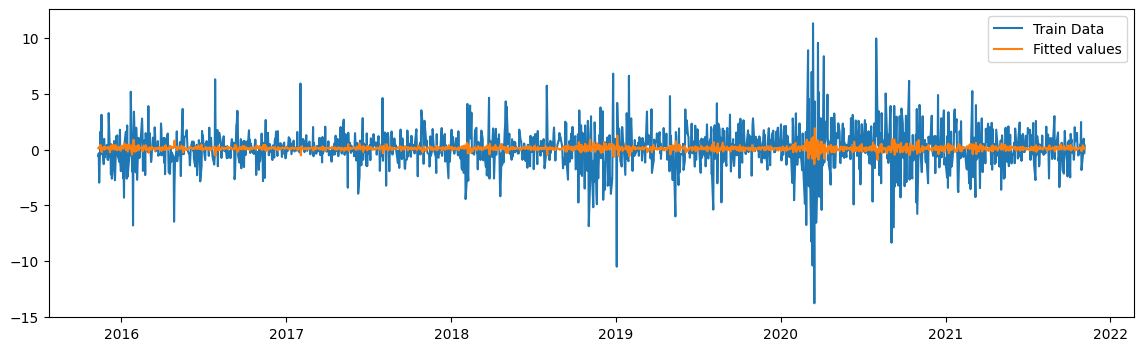

: 

: 

: 

In [ ]:
# Compare actual training data with in-sample fitted values
# Good fit should track major movements while avoiding overfitting to noise
fig, ax = plt.subplots(figsize=(14, 4))
ax.plot(train_sample, label='Train Data')
ax.plot(arima_fit.fittedvalues, label='Fitted values')
plt.legend(loc = 'best')
plt.show()

In [ ]:
%%time
# --- Systematic hyperparameter optimization using grid search ---
# Exhaustively search AR and MA orders to minimize information criteria
# Lower values indicate better models, with penalties for complexity

# Define endogenous variable for modeling
endog = train_sample['Close']

# Evaluate multiple information criteria for robustness
# AIC: Akaike Information Criterion
# AICC: Corrected AIC for small samples
# BIC: Bayesian Information Criterion (stricter penalty for complexity)
information_criteria = ['aic', 'aicc', 'bic']

for criterion in information_criteria:
    def objfunc(p, q, endog):
        fit = ARIMA(endog, order=(int(p), 0, int(q))).fit()
        return getattr(fit, criterion)

    # Search AR (p) and MA (q) orders from 0 to 4
    # First slice controls AR order, second controls MA order
    grid = (slice(0, 5), slice(0, 5))

    # Brute force optimization to find order minimizing the criterion
    result = brute(lambda params: objfunc(params[0], params[1], endog), grid, finish=None)
    print(f"Best order according to {criterion}:", result)

Best order according to aic: [3. 4.]
Best order according to aicc: [3. 4.]
Best order according to bic: [2. 2.]
CPU times: total: 1min 5s
Wall time: 1min 12s


: 

: 

: 

### Comparative Analysis: Simple vs. Complex Models

Fitting multiple ARMA specifications ranging from simple AR/MA models to more complex combinations. This allows us to assess the trade-off between model complexity and goodness-of-fit.

In [ ]:
# Pure autoregressive model AR(1) - simplest specification
# Uses only the immediately preceding observation to predict current value
ar = ARIMA(train_sample, order=(1, 0, 0))
ar = ar.fit()
ar.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                 1508
Model:                 ARIMA(1, 0, 0)   Log Likelihood               -3056.496
Date:                Mon, 10 Nov 2025   AIC                           6118.992
Time:                        18:56:40   BIC                           6134.948
Sample:                             0   HQIC                          6124.935
                               - 1508                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1146      0.043      2.652      0.008       0.030       0.199
ar.L1         -0.1104      0.015     -7.398      0.000      -0.140      -0.081
sigma2         3.3730      0.064     53.044      0.000       3.248       3.498
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):              2591.23
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):               2.86   Skew:                            -0.37
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.38
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

: 

: 

: 

In [ ]:
# Pure moving average model MA(1)
# Models current value as linear combination of current and past error terms
ma = ARIMA(train_sample, order=(0, 0, 1))
ma = ma.fit()
ma.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                 1508
Model:                 ARIMA(0, 0, 1)   Log Likelihood               -3056.908
Date:                Mon, 10 Nov 2025   AIC                           6119.815
Time:                        18:56:48   BIC                           6135.771
Sample:                             0   HQIC                          6125.758
                               - 1508                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1146      0.043      2.648      0.008       0.030       0.199
ma.L1         -0.1057      0.016     -6.700      0.000      -0.137      -0.075
sigma2         3.3750      0.064     52.861      0.000       3.250       3.500
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):              2625.19
Prob(Q):                              0.91   Prob(JB):                         0.00
Heteroskedasticity (H):               2.87   Skew:                            -0.38
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.42
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

: 

: 

: 

In [ ]:
# ARMA(1,1) - balanced model combining one AR and one MA term
# Often performs well for financial returns with short-term dependencies
arima_1 = ARIMA(train_sample, order=(1, 0, 1))
arima_1 = arima_1.fit()
arima_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                 1508
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -3056.084
Date:                Mon, 10 Nov 2025   AIC                           6120.169
Time:                        18:56:57   BIC                           6141.443
Sample:                             0   HQIC                          6128.092
                               - 1508                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1146      0.045      2.547      0.011       0.026       0.203
ar.L1         -0.3259      0.123     -2.640      0.008      -0.568      -0.084
ma.L1          0.2187      0.129      1.698      0.090      -0.034       0.471
sigma2         3.3712      0.064     52.575      0.000       3.246       3.497
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              2610.91
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               2.86   Skew:                            -0.35
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.41
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

: 

: 

: 

In [ ]:
# ARMA(3,4) - more complex model with higher-order terms
# Tests whether additional lags improve fit or lead to overfitting
arima_2 = ARIMA(train_sample, order=(3, 0, 4))
arima_2 = arima_2.fit()
arima_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                 1508
Model:                 ARIMA(3, 0, 4)   Log Likelihood               -3031.005
Date:                Mon, 10 Nov 2025   AIC                           6080.011
Time:                        18:57:06   BIC                           6127.878
Sample:                             0   HQIC                          6097.838
                               - 1508                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1145      0.045      2.555      0.011       0.027       0.202
ar.L1         -2.0921      0.220     -9.495      0.000      -2.524      -1.660
ar.L2         -1.5532      0.387     -4.013      0.000      -2.312      -0.795
ar.L3         -0.3486      0.205     -1.700      0.089      -0.751       0.053
ma.L1          2.0157      0.225      8.950      0.000       1.574       2.457
ma.L2          1.3970      0.383      3.646      0.000       0.646       2.148
ma.L3          0.2066      0.203      1.020      0.308      -0.191       0.604
ma.L4         -0.0745      0.020     -3.754      0.000      -0.113      -0.036
sigma2         3.2571      0.071     45.821      0.000       3.118       3.396
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              1880.92
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               2.76   Skew:                            -0.41
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.41
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

: 

: 

: 

In [ ]:
# ARMA(2,2) - intermediate complexity model
# Suggested by grid search as optimal balance between fit and parsimony
arima_3 = ARIMA(train_sample, order=(2, 0, 2))
arima_3 = arima_3.fit()
arima_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                 1508
Model:                 ARIMA(2, 0, 2)   Log Likelihood               -3034.842
Date:                Mon, 10 Nov 2025   AIC                           6081.684
Time:                        18:57:15   BIC                           6113.595
Sample:                             0   HQIC                          6093.569
                               - 1508                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1145      0.045      2.520      0.012       0.025       0.204
ar.L1         -1.7560      0.026    -67.218      0.000      -1.807      -1.705
ar.L2         -0.9062      0.026    -34.385      0.000      -0.958      -0.855
ma.L1          1.6805      0.033     50.416      0.000       1.615       1.746
ma.L2          0.8204      0.033     24.764      0.000       0.755       0.885
sigma2         3.2770      0.067     48.764      0.000       3.145       3.409
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):              1952.48
Prob(Q):                              0.86   Prob(JB):                         0.00
Heteroskedasticity (H):               2.75   Skew:                            -0.38
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.52
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

: 

: 

: 

### Model Selection Conclusion

Based on information criteria comparison, the ARMA(2, 2) model demonstrates the best trade-off between model complexity and goodness-of-fit. This specification will be used for further analysis and forecasting.

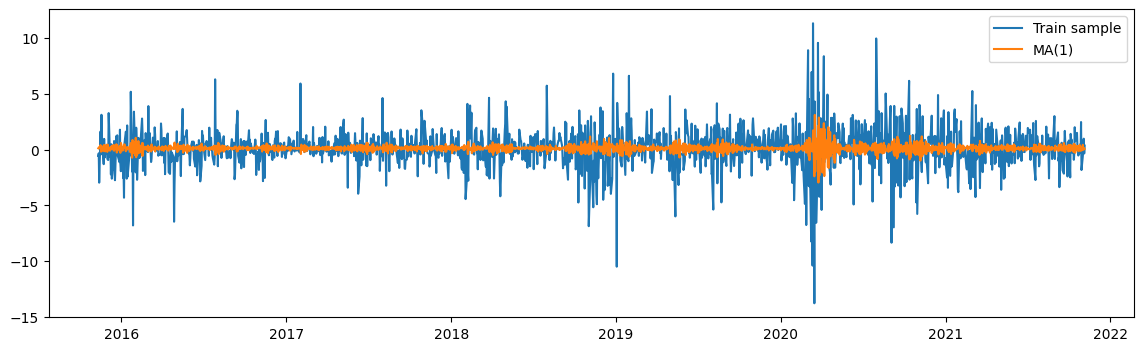

: 

: 

: 

In [ ]:
# Visual comparison of training data vs. fitted values for the selected model
# Assess how well the ARMA(2,2) captures the underlying patterns
fig, ax = plt.subplots(figsize = (14, 4))
ax.plot(train_sample, label = "Train sample")
ax.plot(arima_3.fittedvalues, label = "ARMA(2,2) Fitted")
plt.legend()
plt.show()

In [ ]:
# Quantitative comparison of in-sample performance using RMSE
# Lower RMSE indicates better fit, but must balance against overfitting risk
# Comparing ARMA(2,2), ARMA(1,1), and ARMA(3,4) specifications
print("ARMA(2, 2): {}".format(sklearn.metrics.root_mean_squared_error(train_sample, arima_3.fittedvalues)),
      "ARMA(1, 1): {}".format(sklearn.metrics.root_mean_squared_error(train_sample, arima_1.fittedvalues)),
      "ARMA(3, 4): {}".format(sklearn.metrics.root_mean_squared_error(train_sample, arima_2.fittedvalues)),
      sep="\n"
)

ARMA(2, 2): 1.8103781040357065
ARMA(1, 1): 1.8360909055366414
ARMA(3, 4): 1.8057792027458817


: 

: 

: 